In [16]:
from typing import List
from copy import deepcopy

import collections

import h5py

import matplotlib.pyplot as plt; plt.rcParams.update({"font.family": "serif"})

import pyscf
import pyscf.cc
import pyscf.mcscf

# To get molecular geometries.
import openfermion as of
from openfermion import MolecularData
from openfermionpyscf import run_pyscf

import qiskit
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.primitives import BitArray
from qiskit_aer import AerSimulator  # For MPS Simulator.
from qiskit_aer.noise import NoiseModel
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.primitives import BackendEstimatorV2 as BackendEstimator
from qiskit.transpiler.passes import RemoveFinalMeasurements
from qiskit.qasm2 import dumps
from qiskit_ibm_runtime import QiskitRuntimeService

import ffsim

# To run on hardware.
import qiskit_ibm_runtime
from qiskit_ibm_runtime import SamplerV2 as Sampler

from functools import partial, reduce

import numpy as np

# from qiskit_addon_sqd.fermion import SCIResult, diagonalize_fermionic_hamiltonian, solve_sci_batch
from qiskit_addon_sqd.qubit import solve_qubit, sort_and_remove_duplicates, project_operator_to_subspace

from adaptvqe.pools import DVG_CEO, FullPauliPool, TiledPauliPool
from adaptvqe.convert import cirq_pauli_sum_to_qiskit_pauli_op
from adaptvqe.hamiltonians import XXZHamiltonian
from adaptvqe.algorithms.adapt_vqe import LinAlgAdapt, TensorNetAdapt

In [17]:
ibm_computer: str = "ibm_fez"

service = QiskitRuntimeService(name="dalfaver@msu.edu")
backend = service.backend(ibm_computer)
sampler = Sampler(backend)

qiskit_runtime_service.__init__:WARNING:2026-02-04 12:23:20,641: Instance was not set at service instantiation. Free and trial plan instances will be prioritized. Based on the following filters: (tags: None, region: us-east, eu-de), and available plans: (open), the available account instances are: open-instance. If you need a specific instance set it explicitly either by using a saved account with a saved default instance or passing it in directly to QiskitRuntimeService().
qiskit_runtime_service.backends:WARNING:2026-02-04 12:23:20,641: Using instance: open-instance, plan: open


## Build a tiled pool

In [18]:
max_mpo_bond = 300
dmrg_mps_bond = 30
adapt_mps_bond = 30
l = 4

j_xy = 1
j_z = 1
h = XXZHamiltonian(j_xy, j_z, l, diag_mode="quimb", max_mpo_bond=max_mpo_bond, max_mps_bond=dmrg_mps_bond)
dmrg_energy = h.ground_energy
print(f"Got DMRG energy {dmrg_energy:4.5e}")
pool = FullPauliPool(n=l, max_mpo_bond=max_mpo_bond)

# Run 200 iterations of ADAPT-VQE for small problem instance, selecting randomly among degenerate gradients.
# Form a list of all unique operators ever selected for this small instance.
ixs = []
for _ in range(30):
    my_adapt = TensorNetAdapt(
        pool=pool,
        custom_hamiltonian=h,
        verbose=False,
        threshold=10**-5,
        max_adapt_iter=5,
        max_opt_iter=10000,
        sel_criterion="gradient",
        recycle_hessian=False,
        rand_degenerate=True,
        max_mpo_bond=100,
        max_mps_bond = 20
    )
    my_adapt.run()
    data = my_adapt.data
    for i in data.result.ansatz.indices:
        if i not in ixs:
            ixs.append(i)

print(f"Pool will be tiled from {len(ixs)} ops")
source_ops = [pool.operators[index].operator for index in ixs]

Got DMRG energy -6.46410e+00

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operator(s) added to ansatz: [228]
Gradients: [np.float64(4.000000000000005)]
Initial energy: -3.0000000000000044
Optimizing energy with indices [228]...
Starting point: [np.float64(0.0)]

Current energy: -4.236067977499795
(change of -1.2360679774997907)
Current ansatz: [228]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.853338685696158
Operator(s) added to ansatz: [74]
Gradients: [np.float64(4.000000000000003)]
Initial energy: -4.236067977499795
Optimizing energy with indices [228, 74]...
Starting point: [np.float64(-0.5535743588970451), np.float64(0.0)]

Current energy: -5.999999999998185
(change of -1.7639320224983894)
Current ansatz: [228, 74]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 op

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.91752214895575
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.4850687898689516)]
Initial energy: -6.12310562561065
Optimizing energy with indices [228, 74, 228, 210]...
Starting point: [np.float64(-0.7853983869831829), np.float64(-0.7853991695302484), np.float64(0.12248869758310722), np.float64(0.0)]

Current energy: -6.327276154816652
(change of -0.2041705292060021)
Current ansatz: [228, 74, 228, 210]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240964056413549
Operator(s) added to ansatz: [198]
Gradients: [np.float64(2.089491640733207)]
Initial energy: -6.327276154816652
Optimizing energy with indices [228, 74, 228, 210, 198]...
Starting point: [np.float64(-0.7853984379181662), np.float64(-0.7853991591701309), np.float64(0.1635702892992542), np.float64(0.16356997348665914), np.float64(0.0)]

Current energy: -6.464101615069475
(change of -0.1368254602528225)
Current ansat

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526199442337
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.485071047429203)]
Initial energy: -6.123105625617639
Optimizing energy with indices [244, 79, 228, 210]...
Starting point: [np.float64(0.785398163526392), np.float64(0.7853981635468582), np.float64(0.12248927934340699), np.float64(0.0)]

Current energy: -6.327276154819987
(change of -0.20417052920234813)
Current ansatz: [244, 79, 228, 210]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240964041846258
Operator(s) added to ansatz: [108]
Gradients: [np.float64(2.0894916434588646)]
Initial energy: -6.327276154819987
Optimizing energy with indices [244, 79, 228, 210, 108]...
Starting point: [np.float64(0.7853981591889313), np.float64(0.7853981652005415), np.float64(0.16357028651334282), np.float64(0.1635699720499918), np.float64(0.0)]

Current energy: -6.464101615072751
(change of -0.13682546025276388)
Current ansatz

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 0.0001350560817700983

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240964041846258 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operator(s) added to ansatz: [244]
Gradients: [np.float64(-4.000000000000005)]
Initial energy: -3.0000000000000044
Optimizing energy with indices [244]...
Starting point: [np.float64(0.0)]

Current energy: -4.236067977499799
(change of -1.2360679774997942)
Current ansatz: [244]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.853338685696167
Operator(s) added to ansatz: [26]
Gradients: [np.float64(-4.000000000000007)]
Initial energy: -4.236067977499799
Optimizing energy with indices [244, 26]...
Starting point: [np.float64(0.5535743588970456), np.float

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000014
(change of -1.7639320225002155)
Current ansatz: [244, 26]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971132747
Operator(s) added to ansatz: [228]
Gradients: [np.float64(-2.0000000000000018)]
Initial energy: -6.000000000000014
Optimizing energy with indices [244, 26, 228]...
Starting point: [np.float64(0.7853981718257763), np.float64(0.7853981815917102), np.float64(0.0)]


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.123105625617647
(change of -0.12310562561763305)
Current ansatz: [244, 26, 228]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526199440323
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.485071047428078)]
Initial energy: -6.123105625617647
Optimizing energy with indices [244, 26, 228, 210]...
Starting point: [np.float64(0.7853981611549227), np.float64(0.7853981650265573), np.float64(0.1224892793431165), np.float64(0.0)]


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.32727615481998
(change of -0.20417052920233303)
Current ansatz: [244, 26, 228, 210]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240964040371926
Operator(s) added to ansatz: [108]
Gradients: [np.float64(2.0894916447538883)]
Initial energy: -6.32727615481998
Optimizing energy with indices [244, 26, 228, 210, 108]...
Starting point: [np.float64(0.785398156811469), np.float64(0.785398154431449), np.float64(0.16357028642350993), np.float64(0.16356997171157828), np.float64(0.0)]

Current energy: -6.464101615015089
(change of -0.13682546019510866)
Current ansatz: [244, 26, 228, 210, 108]
Performing final convergence check...
Total gradient norm: 0.0001694384918916013

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240964040371926 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 0.0001372794514110759

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240964056871159 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operator(s) added to ansatz: [244]
Gradients: [np.float64(-4.000000000000005)]
Initial energy: -3.0000000000000044
Optimizing energy with indices [244]...
Starting point: [np.float64(0.0)]

Current energy: -4.236067977499799
(change of -1.2360679774997942)
Current ansatz: [244]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.853338685696167
Operator(s) added to ansatz: [31]
Gradients: [np.float64(4.000000000000007)]
Initial energy: -4.236067977499799
Optimizing energy with indices [244, 31]...
Starting point: [np.float64(0.5535743588970456), np.float6

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.327276154819971
(change of -0.20417052920232592)
Current ansatz: [244, 31, 225, 108]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240964044770192
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.089491640892038)]
Initial energy: -6.327276154819971
Optimizing energy with indices [244, 31, 225, 108, 210]...
Starting point: [np.float64(0.7853981488982182), np.float64(-0.7853982105488547), np.float64(-0.16357028669175525), np.float64(-0.16356997272084708), np.float64(0.0)]

Current energy: -6.464101614722433
(change of -0.13682545990246187)
Current ansatz: [244, 31, 225, 108, 210]
Performing final convergence check...
Total gradient norm: 0.0002850596421335381

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240964044770192 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating 

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -5.999999999998188
(change of -1.7639320224983894)
Current ansatz: [225, 79]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971140572
Operator(s) added to ansatz: [225]
Gradients: [np.float64(1.999999999994421)]
Initial energy: -5.999999999998188
Optimizing energy with indices [225, 79, 225]...
Starting point: [np.float64(0.7853985607314237), np.float64(0.7853989420959421), np.float64(0.0)]

Current energy: -6.123105625610644
(change of -0.12310562561245586)
Current ansatz: [225, 79, 225]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917522148955813
Operator(s) added to ansatz: [147]
Gradients: [np.float64(2.4850687898689876)]
Initial energy: -6.123105625610644
Optimizing energy with indices [225, 79, 225, 147]...
Starting point: [np.float64(0.7853983869831812), np.float64(0.7853991695302517), np.float64(-0.12248

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526155305602
Operator(s) added to ansatz: [228]
Gradients: [np.float64(-2.485071021855692)]
Initial energy: -6.123105625475225
Optimizing energy with indices [228, 74, 201, 228]...
Starting point: [np.float64(-0.7854038547370663), np.float64(-0.7854037258579853), np.float64(0.12248927291523236), np.float64(0.0)]


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.327276154553896
(change of -0.20417052907867106)
Current ansatz: [228, 74, 201, 228]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240988012351095
Operator(s) added to ansatz: [141]
Gradients: [np.float64(2.0894918949972774)]
Initial energy: -6.327276154553896
Optimizing energy with indices [228, 74, 201, 228, 141]...
Starting point: [np.float64(-0.7853981604388705), np.float64(-0.7853981095764203), np.float64(0.16357577726935094), np.float64(0.16357144252244624), np.float64(0.0)]

Current energy: -6.464101615061034
(change of -0.13682546050713817)
Current ansatz: [228, 74, 201, 228, 141]
Performing final convergence check...
Total gradient norm: 0.00014295789237530517

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240988012351095 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating 

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526200767302
Operator(s) added to ansatz: [201]
Gradients: [np.float64(-2.4850710481676668)]
Initial energy: -6.123105625617644
Optimizing energy with indices [241, 79, 216, 201]...
Starting point: [np.float64(-0.7853981624814353), np.float64(0.7853981626766198), np.float64(-0.12248927953370452), np.float64(0.0)]

Current energy: -6.327276154819713
(change of -0.20417052920206924)
Current ansatz: [241, 79, 216, 201]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240962580531864
Operator(s) added to ansatz: [225]
Gradients: [np.float64(2.0894929267349696)]
Initial energy: -6.327276154819713
Optimizing energy with indices [241, 79, 216, 201, 225]...
Starting point: [np.float64(-0.7853981639998062), np.float64(0.7853981647930687), np.float64(-0.16357019740839962), np.float64(0.16356963668286162), np.float64(0.0)]

Current energy: -6.464101615134677
(change of -0.1368254603149639)
Current 

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000011
(change of -1.7639320225002146)
Current ansatz: [241, 31]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971132743
Operator(s) added to ansatz: [228]
Gradients: [np.float64(-2.0000000000000018)]
Initial energy: -6.000000000000011
Optimizing energy with indices [241, 31, 228]...
Starting point: [np.float64(-0.7853981718257756), np.float64(-0.7853981815917112), np.float64(0.0)]

Current energy: -6.123105625617647
(change of -0.1231056256176366)
Current ansatz: [241, 31, 228]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526199441852
Operator(s) added to ansatz: [135]
Gradients: [np.float64(-2.4850710474289297)]
Initial energy: -6.123105625617647
Optimizing energy with indices [241, 31, 228, 135]...
Starting point: [np.float64(-0.7853981609748782), np.float64(-0.785398165605737), np.float64(0.1

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.327276154820001
(change of -0.20417052920235346)
Current ansatz: [241, 31, 228, 135]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240964034720183
Operator(s) added to ansatz: [198]
Gradients: [np.float64(2.08949164971714)]
Initial energy: -6.327276154820001
Optimizing energy with indices [241, 31, 228, 135, 198]...
Starting point: [np.float64(-0.7853981634928596), np.float64(-0.7853981639638683), np.float64(0.16357028607891516), np.float64(0.16356997041450977), np.float64(0.0)]

Current energy: -6.464101615072796
(change of -0.13682546025279496)
Current ansatz: [241, 31, 228, 135, 198]
Performing final convergence check...
Total gradient norm: 0.000135045259020095

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240964034720183 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.327276154819981
(change of -0.20417052920233836)
Current ansatz: [244, 31, 228, 135]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240964044040272
Operator(s) added to ansatz: [108]
Gradients: [np.float64(2.089491641532528)]
Initial energy: -6.327276154819981
Optimizing energy with indices [244, 31, 228, 135, 108]...
Starting point: [np.float64(0.7853981435358092), np.float64(-0.785398170851247), np.float64(0.16357028664718481), np.float64(0.163569972553437), np.float64(0.0)]

Current energy: -6.464101615071864
(change of -0.1368254602518828)
Current ansatz: [244, 31, 228, 135, 108]
Performing final convergence check...
Total gradient norm: 0.00013566218725941578

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240964044040272 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list o

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -5.999999999417229
(change of -1.3737154597822627)
Current ansatz: [210, 244, 26]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958970181085
Operator(s) added to ansatz: [228]
Gradients: [np.float64(-1.9999999998057474)]
Initial energy: -5.999999999417229
Optimizing energy with indices [210, 244, 26, 228]...
Starting point: [np.float64(9.855378896905417e-06), np.float64(0.7853981714335029), np.float64(0.785398140734149), np.float64(0.0)]

Current energy: -6.123105625041491
(change of -0.12310562562426242)
Current ansatz: [210, 244, 26, 228]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526200501841
Operator(s) added to ansatz: [147]
Gradients: [np.float64(2.4850710482493232)]
Initial energy: -6.123105625041491
Optimizing energy with indices [210, 244, 26, 228, 147]...
Starting point: [np.float64(9.69330165277085

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 19.595917942265466
Operator(s) added to ansatz: [228]
Gradients: [np.float64(4.000000000000005)]
Initial energy: -3.0000000000000044
Optimizing energy with indices [228]...
Starting point: [np.float64(0.0)]

Current energy: -4.236067977499795
(change of -1.2360679774997907)
Current ansatz: [228]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.853338685696158
Operator(s) added to ansatz: [26]
Gradients: [np.float64(-4.000000000000003)]
Initial energy: -4.236067977499795
Optimizing energy with indices [228, 26]...
Starting point: [np.float64(-0.5535743588970451), np.float64(0.0)]


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -5.999999999929516
(change of -1.7639320224297208)
Current ansatz: [228, 26]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971647986
Operator(s) added to ansatz: [225]
Gradients: [np.float64(2.0000000000193667)]
Initial energy: -5.999999999929516
Optimizing energy with indices [228, 26, 225]...
Starting point: [np.float64(-0.7853947065773501), np.float64(0.785399377726245), np.float64(0.0)]

Current energy: -6.12310562556249
(change of -0.12310562563297367)
Current ansatz: [228, 26, 225]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526201775827
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.485071048468285)]
Initial energy: -6.12310562556249
Optimizing energy with indices [228, 26, 225, 210]...
Starting point: [np.float64(-0.785394706577256), np.float64(0.7853985308794286), np.float64(-0.122489

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000005
(change of -1.7639320225002093)
Current ansatz: [241, 79]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971132733
Operator(s) added to ansatz: [225]
Gradients: [np.float64(1.9999999999999996)]
Initial energy: -6.000000000000005
Optimizing energy with indices [241, 79, 225]...
Starting point: [np.float64(-0.785398171825775), np.float64(0.7853981815917083), np.float64(0.0)]

Current energy: -6.123105625617647
(change of -0.12310562561764193)
Current ansatz: [241, 79, 225]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.91752619944251
Operator(s) added to ansatz: [135]
Gradients: [np.float64(-2.485071047429297)]
Initial energy: -6.123105625617647
Optimizing energy with indices [241, 79, 225, 135]...
Starting point: [np.float64(-0.7853981627578538), np.float64(0.78539816425353), np.float64(-0.122489

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.327276154819991
(change of -0.2041705292023357)
Current ansatz: [244, 31, 216, 225]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240964042638306
Operator(s) added to ansatz: [201]
Gradients: [np.float64(-2.0894916427634773)]
Initial energy: -6.327276154819991
Optimizing energy with indices [244, 31, 216, 225, 201]...
Starting point: [np.float64(0.7853981628939728), np.float64(-0.7853981669250067), np.float64(-0.16357028656166703), np.float64(-0.16356997223173272), np.float64(0.0)]

Current energy: -6.464101615072744
(change of -0.13682546025275322)
Current ansatz: [244, 31, 216, 225, 201]
Performing final convergence check...
Total gradient norm: 0.00013507009758898745

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240964042638306 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 9.797958971132738
Operator(s) added to ansatz: [228]
Gradients: [np.float64(-2.000000000000001)]
Initial energy: -6.000000000000009
Optimizing energy with indices [244, 79, 228]...
Starting point: [np.float64(0.7853981718257751), np.float64(0.7853981815917103), np.float64(0.0)]

Current energy: -6.123105625617639
(change of -0.12310562561763039)
Current ansatz: [244, 79, 228]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526199442337
Operator(s) added to ansatz: [135]
Gradients: [np.float64(-2.4850710474292033)]
Initial energy: -6.123105625617639
Optimizing energy with indices [244, 79, 228, 135]...
Starting point: [np.float64(0.785398163526392), np.float64(0.7853981635468582), np.float64(0.12248927934340699), np.float64(0.0)]


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.327276154819991
(change of -0.20417052920235168)
Current ansatz: [244, 79, 228, 135]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240964041381248
Operator(s) added to ansatz: [198]
Gradients: [np.float64(2.0894916438672313)]
Initial energy: -6.327276154819991
Optimizing energy with indices [244, 79, 228, 135, 198]...
Starting point: [np.float64(0.7853981553846432), np.float64(0.7853981604652992), np.float64(0.16357028648499042), np.float64(0.16356997194327144), np.float64(0.0)]

Current energy: -6.464101615069744
(change of -0.13682546024975295)
Current ansatz: [244, 79, 228, 135, 198]
Performing final convergence check...
Total gradient norm: 0.00013698140305267725

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240964041381248 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating li

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000009
(change of -1.7639320225002102)
Current ansatz: [244, 79]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971132738
Operator(s) added to ansatz: [225]
Gradients: [np.float64(2.0000000000000018)]
Initial energy: -6.000000000000009
Optimizing energy with indices [244, 79, 225]...
Starting point: [np.float64(0.7853981718257751), np.float64(0.7853981815917103), np.float64(0.0)]

Current energy: -6.123105625617651
(change of -0.12310562561764193)
Current ansatz: [244, 79, 225]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526199444833
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.485071047430588)]
Initial energy: -6.123105625617651
Optimizing energy with indices [244, 79, 225, 210]...
Starting point: [np.float64(0.7853981583089785), np.float64(0.785398168718093), np.float64(-0.12248

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 0.00013840069558915347

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240964057733311 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operator(s) added to ansatz: [244]
Gradients: [np.float64(-4.000000000000005)]
Initial energy: -3.0000000000000044
Optimizing energy with indices [244]...
Starting point: [np.float64(0.0)]

Current energy: -4.236067977499799
(change of -1.2360679774997942)
Current ansatz: [244]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.853338685696167
Operator(s) added to ansatz: [31]
Gradients: [np.float64(4.000000000000007)]
Initial energy: -4.236067977499799
Optimizing energy with indices [244, 31]...
Starting point: [np.float64(0.5535743588970456), np.float

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.327276154819992
(change of -0.2041705292023419)
Current ansatz: [241, 74, 216, 30]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240964042692924
Operator(s) added to ansatz: [201]
Gradients: [np.float64(-2.089491642715508)]
Initial energy: -6.327276154819992
Optimizing energy with indices [241, 74, 216, 30, 201]...
Starting point: [np.float64(-0.7853981637618467), np.float64(-0.7853981622244294), np.float64(-0.16357028656499617), np.float64(-0.16356997224426872), np.float64(0.0)]

Current energy: -6.464101615072681
(change of -0.13682546025268927)
Current ansatz: [241, 74, 216, 30, 201]
Performing final convergence check...
Total gradient norm: 0.00013512004602194824

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240964042692924 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating li

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -5.999999999998188
(change of -1.7639320224983894)
Current ansatz: [225, 79]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971140572
Operator(s) added to ansatz: [228]
Gradients: [np.float64(-1.9999999999944214)]
Initial energy: -5.999999999998188
Optimizing energy with indices [225, 79, 228]...
Starting point: [np.float64(0.7853985607314237), np.float64(0.7853989420959421), np.float64(0.0)]

Current energy: -6.123105625610647
(change of -0.12310562561245852)
Current ansatz: [225, 79, 228]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917522148955765
Operator(s) added to ansatz: [135]
Gradients: [np.float64(-2.4850687898689605)]
Initial energy: -6.123105625610647
Optimizing energy with indices [225, 79, 228, 135]...
Starting point: [np.float64(0.7853983869831845), np.float64(0.7853991695302365), np.float64(0.122

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917522148955772
Operator(s) added to ansatz: [198]
Gradients: [np.float64(2.4850687898689667)]
Initial energy: -6.123105625610641
Optimizing energy with indices [225, 26, 228, 198]...
Starting point: [np.float64(0.7853983869831882), np.float64(0.7853991695302422), np.float64(0.12248869758311211), np.float64(0.0)]

Current energy: -6.327276154816351
(change of -0.20417052920570988)
Current ansatz: [225, 26, 228, 198]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240962567144909
Operator(s) added to ansatz: [135]
Gradients: [np.float64(-2.0894929485633114)]
Initial energy: -6.327276154816351
Optimizing energy with indices [225, 26, 228, 198, 135]...
Starting point: [np.float64(0.7853984388877605), np.float64(0.7853991591701964), np.float64(0.16357019849077953), np.float64(-0.16356963170305544), np.float64(0.0)]

Current energy: -6.4641016151321296
(change of -0.13682546031577836)
Current a

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917506431665617
Operator(s) added to ansatz: [228]
Gradients: [np.float64(-2.4850600293890643)]
Initial energy: -6.123105625548017
Optimizing energy with indices [228, 79, 201, 228]...
Starting point: [np.float64(-0.7853977521525508), np.float64(0.7853977933716614), np.float64(0.1224864400623345), np.float64(0.0)]


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.327276154816648
(change of -0.2041705292686311)
Current ansatz: [228, 79, 201, 228]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.2409625787176335
Operator(s) added to ansatz: [216]
Gradients: [np.float64(2.089492926747546)]
Initial energy: -6.327276154816648
Optimizing energy with indices [228, 79, 201, 228, 216]...
Starting point: [np.float64(-0.7853977521525458), np.float64(0.7853988798879336), np.float64(0.16357019699115416), np.float64(0.16356963656316684), np.float64(0.0)]

Current energy: -6.464101615068975
(change of -0.1368254602523269)
Current ansatz: [228, 79, 201, 228, 216]
Performing final convergence check...
Total gradient norm: 0.00013734918227250974

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.2409625787176335 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating li

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.91752619944251
Operator(s) added to ansatz: [198]
Gradients: [np.float64(2.4850710474292965)]
Initial energy: -6.123105625617647
Optimizing energy with indices [241, 79, 225, 198]...
Starting point: [np.float64(-0.7853981627578538), np.float64(0.78539816425353), np.float64(-0.12248927934343061), np.float64(0.0)]

Current energy: -6.327276154819986
(change of -0.20417052920233836)
Current ansatz: [241, 79, 225, 198]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240964058377264
Operator(s) added to ansatz: [45]
Gradients: [np.float64(-2.089491628942172)]
Initial energy: -6.327276154819986
Optimizing energy with indices [241, 79, 225, 198, 45]...
Starting point: [np.float64(-0.7853981662933148), np.float64(0.7853981545803549), np.float64(-0.16357028752134434), np.float64(-0.16356997584374114), np.float64(0.0)]


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.464101615072489
(change of -0.13682546025250364)
Current ansatz: [241, 79, 225, 198, 45]
Performing final convergence check...
Total gradient norm: 0.00013521654489571786

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240964058377264 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operator(s) added to ansatz: [244]
Gradients: [np.float64(-4.000000000000005)]
Initial energy: -3.0000000000000044
Optimizing energy with indices [244]...
Starting point: [np.float64(0.0)]

Current energy: -4.236067977499799
(change of -1.2360679774997942)
Current ansatz: [244]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.853338685696167
Operator(s) added to ansatz: [79]
Gradients: [np.float64(-4.000000

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000009
(change of -1.7639320225002102)
Current ansatz: [244, 79]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971132738
Operator(s) added to ansatz: [228]
Gradients: [np.float64(-2.000000000000001)]
Initial energy: -6.000000000000009
Optimizing energy with indices [244, 79, 228]...
Starting point: [np.float64(0.7853981718257751), np.float64(0.7853981815917103), np.float64(0.0)]

Current energy: -6.123105625617639
(change of -0.12310562561763039)
Current ansatz: [244, 79, 228]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526199442337
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.485071047429203)]
Initial energy: -6.123105625617639
Optimizing energy with indices [244, 79, 228, 210]...
Starting point: [np.float64(0.785398163526392), np.float64(0.7853981635468582), np.float64(0.122489

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 6.240964041846258
Operator(s) added to ansatz: [147]
Gradients: [np.float64(2.0894916434588646)]
Initial energy: -6.327276154819987
Optimizing energy with indices [244, 79, 228, 210, 147]...
Starting point: [np.float64(0.7853981591889313), np.float64(0.7853981652005415), np.float64(0.16357028651334282), np.float64(0.1635699720499918), np.float64(0.0)]

Current energy: -6.464101615072685
(change of -0.13682546025269726)
Current ansatz: [244, 79, 228, 210, 147]
Performing final convergence check...
Total gradient norm: 0.00013508605784767053

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240964041846258 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operator(s) added to ansatz: [241]
Gradients: [np.float64(4.000000000000005)]
Initial energy: -3.000000000000

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000005
(change of -1.7639320225002093)
Current ansatz: [241, 79]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971132733
Operator(s) added to ansatz: [228]
Gradients: [np.float64(-2.0)]
Initial energy: -6.000000000000005
Optimizing energy with indices [241, 79, 228]...
Starting point: [np.float64(-0.785398171825775), np.float64(0.7853981815917083), np.float64(0.0)]

Current energy: -6.123105625617642
(change of -0.1231056256176366)
Current ansatz: [241, 79, 228]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526199441697
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.485071047428846)]
Initial energy: -6.123105625617642
Optimizing energy with indices [241, 79, 228, 210]...
Starting point: [np.float64(-0.785398162647287), np.float64(0.7853981641254796), np.float64(0.1224892793433147), n

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 0.00033002084338061577

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.24096404138082 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operator(s) added to ansatz: [244]
Gradients: [np.float64(-4.000000000000005)]
Initial energy: -3.0000000000000044
Optimizing energy with indices [244]...
Starting point: [np.float64(0.0)]

Current energy: -4.236067977499799
(change of -1.2360679774997942)
Current ansatz: [244]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.853338685696167
Operator(s) added to ansatz: [79]
Gradients: [np.float64(-4.000000000000007)]
Initial energy: -4.236067977499799
Optimizing energy with indices [244, 79]...
Starting point: [np.float64(0.5535743588970456), np.float

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 9.797958971132738
Operator(s) added to ansatz: [228]
Gradients: [np.float64(-2.000000000000001)]
Initial energy: -6.000000000000009
Optimizing energy with indices [244, 79, 228]...
Starting point: [np.float64(0.7853981718257751), np.float64(0.7853981815917103), np.float64(0.0)]

Current energy: -6.123105625617639
(change of -0.12310562561763039)
Current ansatz: [244, 79, 228]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526199442337
Operator(s) added to ansatz: [147]
Gradients: [np.float64(2.4850710474292024)]
Initial energy: -6.123105625617639
Optimizing energy with indices [244, 79, 228, 147]...
Starting point: [np.float64(0.785398163526392), np.float64(0.7853981635468582), np.float64(0.12248927934340699), np.float64(0.0)]

Current energy: -6.327276154819699
(change of -0.20417052920205947)
Current ansatz: [244, 79, 228, 147]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 o

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526200048677
Operator(s) added to ansatz: [135]
Gradients: [np.float64(-2.4850710477671427)]
Initial energy: -6.123105625617647
Optimizing energy with indices [244, 74, 225, 135]...
Starting point: [np.float64(0.7853981633976963), np.float64(-0.7853981633977503), np.float64(-0.12248927943049101), np.float64(0.0)]

Current energy: -6.327276154819704
(change of -0.2041705292020568)
Current ansatz: [244, 74, 225, 135]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240962580531842
Operator(s) added to ansatz: [198]
Gradients: [np.float64(2.0894929267348785)]
Initial energy: -6.327276154819704
Optimizing energy with indices [244, 74, 225, 135, 198]...
Starting point: [np.float64(0.7853981633998764), np.float64(-0.785398163399414), np.float64(-0.16357019740837914), np.float64(0.1635696366828772), np.float64(0.0)]

Current energy: -6.4641016151353945
(change of -0.13682546031569043)
Current a

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526199444833
Operator(s) added to ansatz: [135]
Gradients: [np.float64(-2.485071047430588)]
Initial energy: -6.123105625617651
Optimizing energy with indices [244, 79, 225, 135]...
Starting point: [np.float64(0.7853981583089785), np.float64(0.785398168718093), np.float64(-0.12248927934376257), np.float64(0.0)]

Current energy: -6.327276154819723
(change of -0.2041705292020719)
Current ansatz: [244, 79, 225, 135]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240962580529992
Operator(s) added to ansatz: [198]
Gradients: [np.float64(2.089492926737967)]
Initial energy: -6.327276154819723
Optimizing energy with indices [244, 79, 225, 135, 198]...
Starting point: [np.float64(0.7853981707487593), np.float64(0.7853981900506324), np.float64(-0.16357019740853293), np.float64(0.16356963668217434), np.float64(0.0)]

Current energy: -6.4641016145584835
(change of -0.1368254597387608)
Current ansat

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.91752620004858
Operator(s) added to ansatz: [198]
Gradients: [np.float64(2.4850710477670868)]
Initial energy: -6.123105625617647
Optimizing energy with indices [244, 74, 228, 198]...
Starting point: [np.float64(0.7853981659552435), np.float64(-0.7853981611613353), np.float64(0.12248927943047701), np.float64(0.0)]

Current energy: -6.327276154819701
(change of -0.20417052920205414)
Current ansatz: [244, 74, 228, 198]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240962580531868
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.0894929267348714)]
Initial energy: -6.327276154819701
Optimizing energy with indices [244, 74, 228, 198, 210]...
Starting point: [np.float64(0.7853981767050704), np.float64(-0.7853981525341414), np.float64(0.16357019740837964), np.float64(-0.16356963668287866), np.float64(0.0)]

Current energy: -6.464101614750662
(change of -0.13682545993096085)
Current a

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 6.240964035952707
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.0894916486344886)]
Initial energy: -6.327276154819995
Optimizing energy with indices [241, 74, 225, 198, 210]...
Starting point: [np.float64(-0.7853981669996093), np.float64(-0.7853981627952086), np.float64(-0.16357028615401242), np.float64(-0.16356997069742418), np.float64(0.0)]

Current energy: -6.464101615072774
(change of -0.13682546025277897)
Current ansatz: [241, 74, 225, 198, 210]
Performing final convergence check...
Total gradient norm: 0.00013505199547288632

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240964035952707 > 1e-05)
Pool will be tiled from 19 ops


## Run ADAPT at larger size to get a sequence of circuits.

In [19]:
def neel_circuit(nq, start_zero=True):
    circuit = QuantumCircuit(nq)
    for i in range(nq):
        if (i % 2 == 0 and start_zero) or (i % 2 != 0 and not start_zero):
            circuit.x(i)
        else:
            circuit.id(i)
    return circuit

In [20]:
# Now go to the larger size.
new_l = 5 * l
print(f"new_l = {new_l}")
j_xy = 1
j_z = 1
h = XXZHamiltonian(
    j_xy, j_z, new_l,
    store_ref_vector=False,
    diag_mode="quimb", max_mpo_bond=max_mpo_bond, max_mps_bond=dmrg_mps_bond
)
dmrg_energy = h.ground_energy
exact_energy = h.ground_energy
print(f"Got DMRG energy {dmrg_energy:4.5e}")

h_of = h.operator
h_cirq = of.transforms.qubit_operator_to_pauli_sum(h_of)
h_qiskit = cirq_pauli_sum_to_qiskit_pauli_op(h_cirq)

tiled_pool = TiledPauliPool(n=new_l, source_ops=source_ops)
num_ops = len(tiled_pool.operators)
print(f"Tiled pool has {num_ops} operators.")

tn_adapt = TensorNetAdapt(
    pool=tiled_pool,
    custom_hamiltonian=h,
    verbose=True,
    threshold=10**-5,
    max_adapt_iter=30,
    max_opt_iter=10000,
    sel_criterion="gradient",
    recycle_hessian=False,
    rand_degenerate=True,
    max_mpo_bond=max_mpo_bond,
    max_mps_bond=adapt_mps_bond
)
tn_adapt.initialize()
nq = tn_adapt.n

circuits = []
adapt_energies = []
for i in range(30):
    print(f"On iteration {i}.")
    tn_adapt.run_iteration()
    data = tn_adapt.data
    circuit = data.get_circuit(
        tiled_pool, indices=tn_adapt.indices, coefficients=tn_adapt.coefficients,
        include_ref=True
    )
    circuit.measure_all()
    circuits.append(circuit)
    adapt_energies.append(tn_adapt.energy)

new_l = 20
No pre-computed energy for given parameters.
Solving by DMRG with quimb.
Got DMRG energy -3.47299e+01-3.37508e-14j
Tiled pool has 261 operators.

tensor-net-adapt prepared with the following settings:
> Pool: tiled_pauli_pool
> Custom Hamiltonian: XXZ_1_1
> Orbital Optimization: False
> Selection method: gradient
> Convergence criterion: total_g_norm
> Recycling Hessian: False
> Tetris: False (progressive optimization: False)
> Convergence threshold (gradient norm):  1e-05
> Maximum number of iterations:  30
> Candidates per iteration:  1
> Swap-based circuits for LNN connectivity:  False
> Qiskit-transpiler-based circuits for LNN connectivity:  False

Initial energy: -19.00000000000003
On iteration 0.

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: 3.9999999999999996
Operator 1: 4.000000000000045
Operator 2: 4.000000000000009
Operator 3: 3.99999999999999
Operator 4: 4.000000

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -22.420152
         Iterations: 6
         Function evaluations: 56
         Gradient evaluations: 51

Current energy: -22.420152078047067
(change of -0.9348707038084108)
Current ansatz: [237, 243, 230, 239]
On iteration 4.

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: 3.4142135915607605
Operator 1: 1.1675064702076733e-07
Operator 2: 3.4142135915607663
Operator 3: 2.828427183121494
Operator 4: 4.000000000000041
Operator 5: 4.000000000000027
Operator 6: 4.000000000000034
Operator 7: 3.2645854456342907
Operator 9: 2.7995881746527407
Operator 10: -0.9299945419499538
Operator 11: 3.2645854456306553
Operator 12: 2.529170891261288
Operator 13: 3.414213562755344
Operator 15: 3.4142135627553327
Operator 16: 2.828427125510638
Operator 17: 2.828427183121507
Operator 18: -4.000000000000023
Operator 19: 3.4142135915607574
Operator 20: -1.1675064702076733e-07
Opera

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -24.183450
         Iterations: 5
         Function evaluations: 70
         Gradient evaluations: 58

Current energy: -24.183449906601798
(change of -0.8284271247463302)
Current ansatz: [237, 243, 230, 239, 173, 233]
On iteration 6.

*** ADAPT-VQE Iteration 7 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: 2.799588166905677
Operator 1: -0.9299945612422822
Operator 2: 3.2645854393226537
Operator 3: 2.158782371075444
Operator 4: -4.923025773806863e-08
Operator 5: 3.414213550065579
Operator 6: 2.828427100131115
Operator 7: 3.2645854454001446
Operator 9: 2.7995881740383552
Operator 10: -0.9299945439798922
Operator 11: 3.2645854448931315
Operator 12: 2.5291708897862173
Operator 13: 3.4142135601957015
Operator 15: 3.41421356019569
Operator 16: 2.828427120391328
Operator 17: 2.0641736062282887
Operator 18: 1.4899734460066626e-08
Operator 19: 2.7995881669056795
Operator 20: 1.16024419338

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -26.924006
         Iterations: 13
         Function evaluations: 55
         Gradient evaluations: 44

Current energy: -26.924006383691122
(change of -1.2739480436536432)
Current ansatz: [237, 243, 230, 239, 173, 233, 137, 118]
On iteration 8.

*** ADAPT-VQE Iteration 9 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: 2.799588178732206
Operator 1: -0.9299942270533468
Operator 2: 3.2645855935889223
Operator 3: 2.1587826424971457
Operator 5: 3.414213562832952
Operator 6: 2.8284271256658595
Operator 7: 3.1403585173694406
Operator 8: -7.135151537327892e-07
Operator 9: 2.4425822154012433
Operator 10: -1.243986486744714
Operator 11: 2.211174427418179
Operator 12: -1.6346701769511438
Operator 13: 2.096488816706413
Operator 14: -1.8226186683415566
Operator 15: 2.0313239394894245
Operator 16: -1.9295364591823945
Operator 17: 2.0641737723210793
Operator 18: 5.861328436904986e-07
Operator 19

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -28.686229
         Iterations: 17
         Function evaluations: 128
         Gradient evaluations: 113

Current energy: -28.6862289418695
(change of -0.5857408851778274)
Current ansatz: [237, 243, 230, 239, 173, 233, 137, 118, 127, 123]
On iteration 10.

*** ADAPT-VQE Iteration 11 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: 3.06541315263269
Operator 1: -0.6683051854957116
Operator 2: -1.2212369836082001e-08
Operator 3: 2.1810750001395984
Operator 4: -0.7432799730075721
Operator 5: 2.3429108333005138
Operator 6: -1.429839743845426
Operator 7: 2.1898973771125103
Operator 8: -1.6862365619449857
Operator 9: 2.110527152173037
Operator 10: -1.815735520598642
Operator 11: 2.062030692451601
Operator 12: -1.8936134158599827
Operator 13: 2.0301649335861622
Operator 14: -1.9446495030846744
Operator 15: 2.0099714429733195
Operator 16: -1.9775658068313937
Operator 17: 2.6594928722287534


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -30.176069
         Iterations: 20
         Function evaluations: 81
         Gradient evaluations: 69

Current energy: -30.176069376129476
(change of -0.7232984304337506)
Current ansatz: [237, 243, 230, 239, 173, 233, 137, 118, 127, 123, 172, 19]
On iteration 12.

*** ADAPT-VQE Iteration 13 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: -1.055047020299857
Operator 1: 1.4714425790564003
Operator 2: -1.1728612806754035
Operator 3: 2.299630101235744
Operator 4: -1.330117910269097
Operator 5: 2.2200840820449335
Operator 6: -1.6384537152757233
Operator 7: 2.131417508309498
Operator 8: -1.7841599452009405
Operator 9: 2.0794256965132956
Operator 10: -1.8679510164317183
Operator 11: 2.045382261798143
Operator 12: -1.9222470239849179
Operator 13: 2.0222315828891437
Operator 14: -1.9592159141215766
Operator 15: 2.0073650513638377
Operator 16: -1.9834294821449774
Operator 18: 8.93417016874

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -31.150701
         Iterations: 25
         Function evaluations: 105
         Gradient evaluations: 93

Current energy: -31.150700877612543
(change of -0.25116125652171917)
Current ansatz: [237, 243, 230, 239, 173, 233, 137, 118, 127, 123, 172, 19, 38, 40, 59, 61]
On iteration 16.

*** ADAPT-VQE Iteration 17 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: -0.43696700924956644
Operator 1: 1.1355521123336914
Operator 2: 0.05873946071966685
Operator 3: 1.422288759886198
Operator 4: 0.8026273209698246
Operator 5: 1.350306168066335
Operator 6: 0.28560819311395086
Operator 7: -0.2304780764415516
Operator 8: -0.7225194649386538
Operator 9: -0.2956015002075902
Operator 10: -1.0059251970009404
Operator 11: 2.2579348870249953
Operator 12: -1.1797849055187313
Operator 13: 2.1943649379128893
Operator 14: -1.6417370167770526
Operator 15: 2.0614724774649376
Operator 16: -1.8617459697841099
Ope

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -32.008305
         Iterations: 31
         Function evaluations: 149
         Gradient evaluations: 137

Current energy: -32.00830481895166
(change of -0.17929108362255164)
Current ansatz: [237, 243, 230, 239, 173, 233, 137, 118, 127, 123, 172, 19, 38, 40, 59, 61, 63, 48, 50, 192]
On iteration 20.

*** ADAPT-VQE Iteration 21 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: -0.42729913383967244
Operator 1: 1.1303871147121551
Operator 2: 0.08299320547573495
Operator 3: 1.3948835013045664
Operator 4: 0.8593022305194336
Operator 5: 1.2782273988719635
Operator 6: 0.3605810194775855
Operator 7: -0.2726742389150101
Operator 8: -0.5642392705939616
Operator 9: -0.43523550523811766
Operator 10: -0.5928076082228201
Operator 11: -0.41502356400616786
Operator 12: -0.12189830698100199
Operator 13: 1.6050046452453826
Operator 14: 0.15658734599489343
Operator 15: -0.3933442746630689
Operator 16: 

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -32.151516
         Iterations: 28
         Function evaluations: 79
         Gradient evaluations: 68

Current energy: -32.151515879304746
(change of -0.14321106035308873)
Current ansatz: [237, 243, 230, 239, 173, 233, 137, 118, 127, 123, 172, 19, 38, 40, 59, 61, 63, 48, 50, 192, 175]
On iteration 21.

*** ADAPT-VQE Iteration 22 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: -0.9581564924244371
Operator 1: 1.0037619140253289
Operator 2: 0.12548207564937602
Operator 3: 1.3708903688832677
Operator 4: 0.879259781981577
Operator 5: 1.2692326303921186
Operator 6: 0.36749563975954197
Operator 7: -0.2741138996693483
Operator 8: -0.5624909916919544
Operator 9: -0.43597113805164345
Operator 10: -0.5921567949695564
Operator 11: -0.4153079727877984
Operator 12: -0.12153958939953706
Operator 13: 1.6048545041142797
Operator 14: 0.15679515186905513
Operator 15: -0.3933287914941507
Operator 16

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -32.431281
         Iterations: 31
         Function evaluations: 136
         Gradient evaluations: 123

Current energy: -32.43128124249228
(change of -0.15098263916026156)
Current ansatz: [237, 243, 230, 239, 173, 233, 137, 118, 127, 123, 172, 19, 38, 40, 59, 61, 63, 48, 50, 192, 175, 190, 122]
On iteration 23.

*** ADAPT-VQE Iteration 24 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: -1.354449622169385
Operator 1: -0.005380613329815008
Operator 2: 0.12789882443392053
Operator 3: 1.1635432583900402
Operator 4: 0.92239841348187
Operator 5: 1.230747246665353
Operator 6: 0.3875738831643738
Operator 7: -0.27756694290323863
Operator 8: -0.5635339052466427
Operator 9: -0.4306565223131741
Operator 10: -0.6108227782051538
Operator 11: -0.40266063582621836
Operator 12: -0.26430478125685747
Operator 13: 0.04288124377940111
Operator 14: -0.5517780938063466
Operator 15: -0.3971108630397555

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -32.543296
         Iterations: 31
         Function evaluations: 146
         Gradient evaluations: 134

Current energy: -32.543296119256595
(change of -0.11201487676431299)
Current ansatz: [237, 243, 230, 239, 173, 233, 137, 118, 127, 123, 172, 19, 38, 40, 59, 61, 63, 48, 50, 192, 175, 190, 122, 187]
On iteration 24.

*** ADAPT-VQE Iteration 25 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: -1.355271958627534
Operator 1: -0.0029325253141582377
Operator 2: 0.12105784034373093
Operator 3: 1.1729689033381128
Operator 4: 0.9045788427372784
Operator 5: 1.255683916122362
Operator 6: 0.36326647242159266
Operator 7: -0.2624408848383143
Operator 8: -0.6159256395159871
Operator 9: -0.3833024171880348
Operator 10: -0.7223855598997382
Operator 11: -0.5125907221347109
Operator 12: -0.32983663235150246
Operator 13: -0.054765435579500324
Operator 14: -0.6770145254182807
Operator 15: -0.413270

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -32.877388
         Iterations: 33
         Function evaluations: 127
         Gradient evaluations: 114

Current energy: -32.877388055889995
(change of -0.10958597063859088)
Current ansatz: [237, 243, 230, 239, 173, 233, 137, 118, 127, 123, 172, 19, 38, 40, 59, 61, 63, 48, 50, 192, 175, 190, 122, 187, 185, 218, 215]
On iteration 27.

*** ADAPT-VQE Iteration 28 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: -1.3741223012256367
Operator 1: 0.05342835105270696
Operator 2: -0.019743248922044328
Operator 3: 1.3928099725474914
Operator 4: 0.008482457440460722
Operator 5: 0.20062363832956226
Operator 6: 0.04232210147319003
Operator 7: -0.4774697752966367
Operator 8: -0.6994697194571566
Operator 9: -0.5904876460571372
Operator 10: -0.9659819943824286
Operator 11: -0.58867650716956
Operator 12: -0.6039846344790655
Operator 13: -0.09519888043952446
Operator 14: -0.8384667330106685
Operato

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -32.982790
         Iterations: 34
         Function evaluations: 75
         Gradient evaluations: 65

Current energy: -32.982789861114455
(change of -0.10540180522446008)
Current ansatz: [237, 243, 230, 239, 173, 233, 137, 118, 127, 123, 172, 19, 38, 40, 59, 61, 63, 48, 50, 192, 175, 190, 122, 187, 185, 218, 215, 180]
On iteration 28.

*** ADAPT-VQE Iteration 29 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: -1.3781162207113444
Operator 1: 0.09058930591395305
Operator 2: -0.08076506264070757
Operator 3: 0.16753440463245012
Operator 4: -0.5977311187921879
Operator 5: 0.1073694750846838
Operator 6: -0.22530362067506166
Operator 7: -0.46386447140699194
Operator 8: -0.7850667089855162
Operator 9: -0.5865264044884212
Operator 10: -1.0124439852017186
Operator 11: -0.5919311098693254
Operator 12: -0.6392189304045162
Operator 13: -0.10064701917298524
Operator 14: -0.8606824649075905
Op

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -33.076881
         Iterations: 34
         Function evaluations: 155
         Gradient evaluations: 142

Current energy: -33.07688137337122
(change of -0.09409151225676737)
Current ansatz: [237, 243, 230, 239, 173, 233, 137, 118, 127, 123, 172, 19, 38, 40, 59, 61, 63, 48, 50, 192, 175, 190, 122, 187, 185, 218, 215, 180, 243]
On iteration 29.

*** ADAPT-VQE Iteration 30 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: -1.3789237877365759
Operator 1: 0.09308247624953067
Operator 2: -0.0863430839732825
Operator 3: 0.16330932316943894
Operator 4: -0.6075678576135912
Operator 5: 0.10599562011074178
Operator 6: -0.24670270783662077
Operator 7: -0.4687689228410921
Operator 8: -0.8150364406662938
Operator 9: -0.5960948803029331
Operator 10: -1.0724680161843152
Operator 11: -0.6186799804216455
Operator 12: -0.8607148102800595
Operator 13: -0.2814677754512478
Operator 14: -1.030150774324659

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


In [21]:
for circuit in circuits:
    print(circuit.depth())

9
16
23
30
35
42
47
54
59
64
69
76
83
90
97
104
111
118
125
132
139
146
151
158
165
172
179
186
193
200


Text(0, 0.5, 'Energy error')

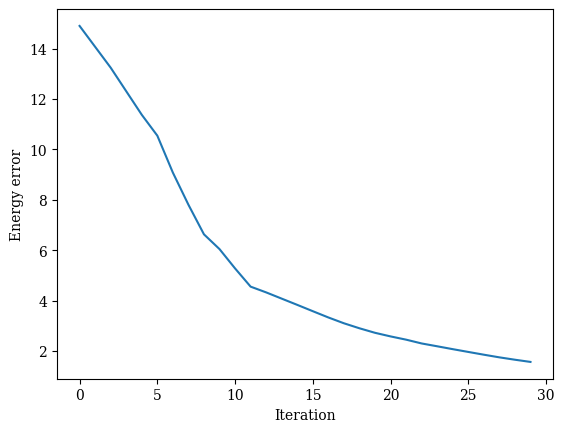

In [22]:
adapt_errors = abs(np.array(adapt_energies) - exact_energy)
fig, ax = plt.subplots()
ax.plot(adapt_errors)
ax.set_xlabel("Iteration")
ax.set_ylabel("Energy error")

In [23]:
adapt_errors = np.abs(np.array(adapt_energies) - exact_energy)

## Get circuit expectation values.

In [24]:
noise_model = NoiseModel.from_backend(backend)
simulator_energies = []
for circuit in circuits:
    sim = AerSimulator(method="matrix_product_state", noise_model=noise_model, matrix_product_state_max_bond_dimension=adapt_mps_bond)
    estimator = BackendEstimator(backend=sim)
    # The circuit needs to be transpiled to the AerSimulator target
    pass_manager = generate_preset_pass_manager(3, sim)
    isa_circuit = pass_manager.run(circuit)
    isa_circuit = RemoveFinalMeasurements()(isa_circuit)
    pub = (isa_circuit, h_qiskit)
    job = estimator.run([pub])
    result = job.result()
    pub_result = result[0]
    exact_value = float(pub_result.data.evs)
    simulator_energies.append(exact_value)

In [25]:
simualtor_errors = np.abs(np.array(simulator_energies) - exact_energy)

Text(0, 0.5, 'Energy error')

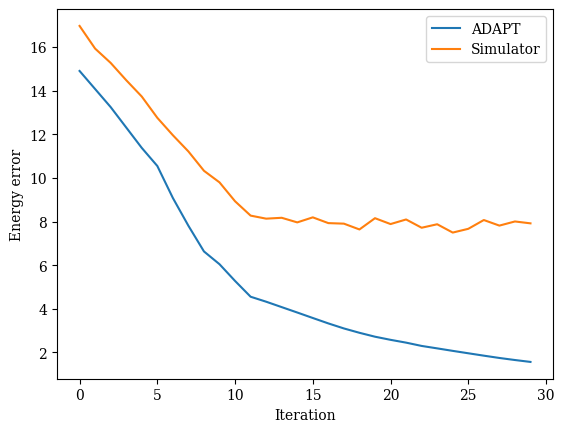

In [26]:
fig, ax = plt.subplots()
ax.plot(adapt_errors, label="ADAPT")
ax.plot(simualtor_errors, label="Simulator")
ax.legend()
ax.set_xlabel("Iteration")
ax.set_ylabel("Energy error")

## Carry out SQD.

In [27]:

# spin_a_layout = list(range(0, 12))
# spin_b_layout = [12, 13, 14, 15, 19, 35, 34, 33, 32, 31, 30, 29]
# initial_layout = spin_a_layout + spin_b_layout
initial_layout = range(nq)

# sim = AerSimulator.from_backend(computer, method="matrix_product_state")
sim = AerSimulator(method="matrix_product_state", noise_model=noise_model, matrix_product_state_max_bond_dimension=4 * adapt_mps_bond)

pass_manager = generate_preset_pass_manager(
    optimization_level=3, backend=sim, initial_layout=initial_layout[:nq]
)


In [28]:
num_shots = 100_000
sampler = Sampler(sim)

In [29]:

bit_arrays = []
counts_list = []
for i, circuit in enumerate(circuits):
    print(f"On circuit {i}/{len(circuits)}")
    pass_manager.pre_init = ffsim.qiskit.PRE_INIT
    to_run = pass_manager.run(circuit)
    print(f"Gate counts (w/ pre-init passes): {to_run.count_ops()}")
    # job = sim.run(to_run)
    # counts = job.result().data()['counts']
    # bit_array = BitArray.from_counts(counts, num_bits=circuit.num_qubits)
    # counts1 = bit_array.get_counts()
    job = sampler.run((circuit,), shots=num_shots)
    data = job.result()[0].data
    bit_array = data['meas']
    counts1 = bit_array.get_counts()
    counts_list.append(counts1)
    bit_arrays.append(deepcopy(bit_array))

On circuit 0/30
Gate counts (w/ pre-init passes): OrderedDict({'measure': 20, 'rz': 11, 'x': 10, 'sx': 10, 'cz': 4, 'barrier': 2})
On circuit 1/30
Gate counts (w/ pre-init passes): OrderedDict({'rz': 22, 'sx': 20, 'measure': 20, 'x': 11, 'cz': 8, 'barrier': 3})
On circuit 2/30
Gate counts (w/ pre-init passes): OrderedDict({'rz': 33, 'sx': 30, 'measure': 20, 'x': 12, 'cz': 12, 'barrier': 4})
On circuit 3/30
Gate counts (w/ pre-init passes): OrderedDict({'rz': 44, 'sx': 40, 'measure': 20, 'cz': 16, 'x': 13, 'barrier': 5})
On circuit 4/30
Gate counts (w/ pre-init passes): OrderedDict({'rz': 53, 'sx': 48, 'measure': 20, 'cz': 18, 'x': 14, 'barrier': 6})
On circuit 5/30
Gate counts (w/ pre-init passes): OrderedDict({'rz': 62, 'sx': 58, 'cz': 22, 'measure': 20, 'x': 15, 'barrier': 7})
On circuit 6/30
Gate counts (w/ pre-init passes): OrderedDict({'rz': 69, 'sx': 66, 'cz': 24, 'measure': 20, 'x': 16, 'barrier': 8})
On circuit 7/30
Gate counts (w/ pre-init passes): OrderedDict({'rz': 87, 'sx':

In [30]:
energies = []
errors = []

for bit_array in bit_arrays[1:]:
    bit_matrix = bit_array.to_bool_array()
    eigvals, eigvecs = solve_qubit(bit_matrix, h_qiskit, k=1)
    min_energy = np.min(eigvals)
    err = abs(min_energy - exact_energy)
    energies.append(min_energy)
    errors.append(err)

Text(0, 0.5, 'Energy error')

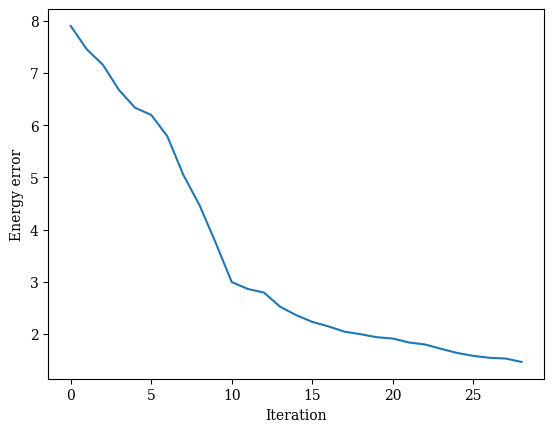

In [31]:
fig, ax = plt.subplots()
ax.plot(errors)
ax.set_xlabel("Iteration")
ax.set_ylabel("Energy error")

## Concatenate mulitple rounds

In [32]:
stacked_energies = []
stacked_errors = []

for i in range(2, len(counts_list) + 1):
    all_counts = collections.Counter()
    tuple_of_counts = tuple(counts_list[:i])
    assert len(tuple_of_counts) == i
    for counts in tuple_of_counts:
        for bitstring, count in counts.items():
            all_counts[bitstring] += count

    bit_array = qiskit.primitives.BitArray.from_counts(all_counts, num_bits=circuits[0].num_qubits)
    bit_matrix = bit_array.to_bool_array()
    eigvals, eigvecs = solve_qubit(bit_matrix, h_qiskit, k=1)
    min_energy = np.min(eigvals)
    err = abs(min_energy - exact_energy)
    stacked_energies.append(min_energy)
    stacked_errors.append(err)


Text(0, 0.5, 'Energy error')

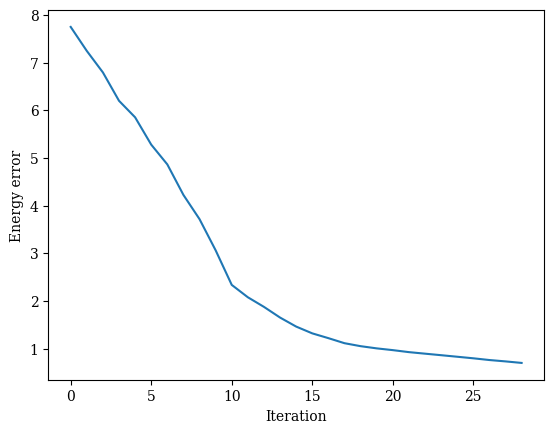

In [33]:
fig, ax = plt.subplots()
ax.plot(stacked_errors)
ax.set_xlabel("Iteration")
ax.set_ylabel("Energy error")

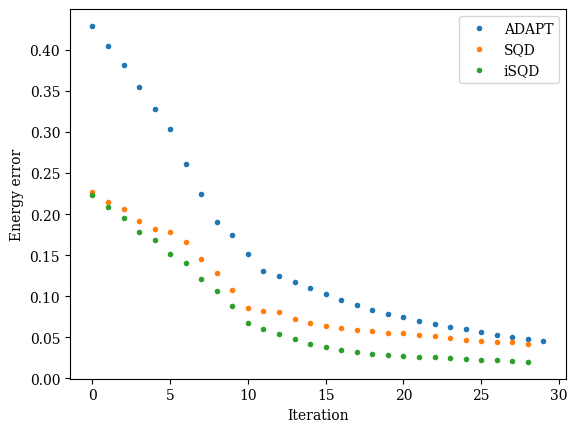

In [34]:
adapt_rel_errors = adapt_errors / abs(exact_energy)
rel_errors = np.array(errors) / abs(exact_energy)
stacked_rel_errors = np.array(stacked_errors) / abs(exact_energy)

fig, ax = plt.subplots()
ax.plot(adapt_rel_errors, '.', label="ADAPT")
ax.plot(rel_errors, '.', label="SQD")
ax.plot(stacked_rel_errors, '.', label="iSQD")
ax.set_xlabel("Iteration")
ax.set_ylabel("Energy error")
ax.legend()

## How many did we keep?

In [35]:
num_kept = []
total_shots = []
for bit_array in bit_arrays:
    bit_matrix = bit_array.to_bool_array()
    original_size = bit_matrix.shape[0]
    bit_matrix = sort_and_remove_duplicates(bit_matrix)
    new_size = bit_matrix.shape[0]
    num_kept.append(new_size)
    total_shots.append(original_size)

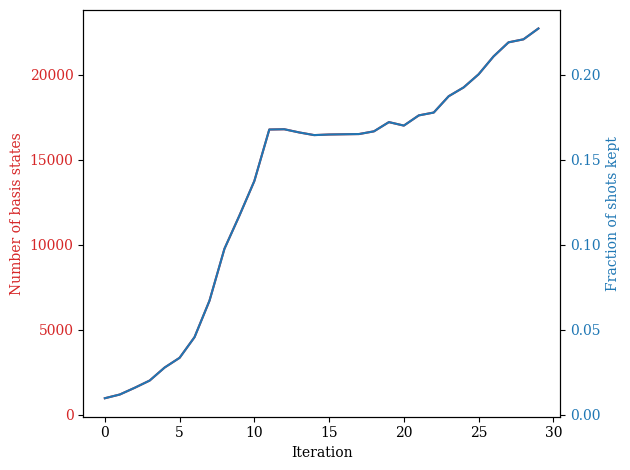

In [36]:
ratio_kept = np.array(num_kept) / np.array(total_shots)

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Number of basis states', color=color)
ax1.plot(num_kept, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Fraction of shots kept', color=color)  # we already handled the x-label with ax1
ax2.plot(ratio_kept, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()

In [37]:
qasm_strs = []
for circuit in circuits:
    # print(circuit.num_qubits)
    # isa_circuit = pass_manager.run(circuit)
    # print(isa_circuit.num_qubits)
    isa_circuit = circuit
    qasm_str = dumps(isa_circuit)
    qasm_strs.append(qasm_str)

In [38]:
f = h5py.File("data/xxz_output.hdf5", "w")
f.create_dataset("qasm_strs", data=qasm_strs)
f.create_dataset("exact_energy", data=exact_energy)
f.create_dataset("adapt_errors", data=np.array(adapt_errors))
f.create_dataset("sqd_errors", data=np.array(errors))
f.create_dataset("isqd_errors", data=np.array(stacked_errors))
f.close()